In [1]:
from  nilearn import plotting
%matplotlib inline
import os
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node
import pandas as pd

Failed to import duecredit due to No module named 'duecredit'
/home/zohyos7/anaconda3/lib/python3.6/site-packages/bids/grabbids/__init__.py:6: FutureWarning: grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8
  warnings.warn("grabbids has been renamed to layout in version 0.6.5, and will be removed in version 0.8", FutureWarning)


In [2]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [3]:
experiment_dir  = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

task_list = ['empathy']

In [4]:
subject_list = os.listdir("/data/wellbeing_bids")
subject_list.remove('dataset_description.json')

subject_list = [sub[-4:] for sub in subject_list]

In [5]:
# TR of functional images
TR = 2

# Smoothing withds used during preprocessing
fwhm = [4, 8]

In [6]:
# SpecifyModel - Generates SPM-specific Model# Speci 
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

In [7]:
# Condition names# Condi 
condition_names = ['neutral','happy','sad','fear']

# Contrasts
cont01 = ['average', 'T', condition_names, [0.25,0.25,0.25,0.25]]
cont02 = ['neutral', 'T', condition_names, [1, 0, 0, 0]]
cont03 = ['happy', 'T', condition_names, [0, 1, 0, 0]]
cont04 = ['sad', 'T', condition_names, [0, 0, 1, 0]]
cont05 = ['fear', 'T', condition_names, [0, 0, 0, 1]]
cont06 = ['neutral > others', 'T', condition_names, [1, -1/3., -1/3., -1/3.]]
cont07 = ['happy > others', 'T', condition_names, [-1/3., 1, -1/3., -1/3.]]
cont08 = ['sad > others', 'T', condition_names, [-1/3., -1/3., 1, -1/3.]]
cont09 = ['fear > others', 'T', condition_names, [-1/3., -1/3., -1/3., 1]]
cont10 = ['happy > neutral','T', condition_names, [-1,1,0,0]]
cont11 = ['sad > neutral','T', condition_names, [-1,0,1,0]]
cont12 = ['fear > neutral','T', condition_names, [-1,0,0,1]]
cont13 = ['happy > sad' ,'T', condition_names, [0,1,-1,0]]
cont14 = ['happy > fear','T', condition_names, [0,1,0,-1]]
cont15 = ['sad > fear','T', condition_names, [0,0,1,-1]]
cont16 = ['happy > sad & fear', 'T', condition_names, [0, 1, -0.5, -0.5]]
cont17 = ['sad & fear > neutral', 'T', condition_names, [-1, 0, 0.5, 0.5]]

cont18 = ['activation', 'F', [cont02, cont03, cont04, cont05]]
cont19 = ['differences_1', 'F', [cont06, cont07, cont08, cont09]]
cont20 = ['differences_2', 'F', [cont10, cont11, cont12, cont13, cont14, cont15]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09, cont10, cont11, cont12, cont13, cont14, cont15, cont16, cont17, cont18, cont19, cont20]

In [8]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/data/wellbeing_bids/sub-%s/func/sub-%s_task-empathy_events.tsv' % (subject_id,subject_id))
    trialinfo['iCond'] = trialinfo['iCond'].apply({1:'neutral',2:'happy',3:'sad',4:'fear'}.get)
    trialinfo.head()
    d = {'neutral':1,'happy':2,'sad':3,'fear':4}
    conditions = []
    onsets = []
    durations = []

    for group in sorted(trialinfo.groupby('iCond'), key=lambda x:d[x[0]]):
        conditions.append(group[0])
        onsets.append(list(group[1].onset))
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations)]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [9]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'task_name',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}',
                         'fwhm-{fwhm_id}_sasub-{subject_id}_task-{task_name}_bold.nii'),
             'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}',
                             'asub-{subject_id}_task-{task_name}_bold.par'),
             'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_name}', 
                             'art.asub-{subject_id}_task-{task_name}_bold_outliers.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_fwhm_id_%s_subject_id_%s_task_name_empathy' % (f, sub), 
                  'sub-%s/task-empathy/fwhm-%s/' % (sub, f))
                 for f in fwhm
                 for sub in subject_list]
datasink.inputs.substitutions = substitutions

In [10]:

# Initiation of the 1st-level analysis workflow# Initi 
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('task_name', 'task_name'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
                                              ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

181003-19:03:24,985 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


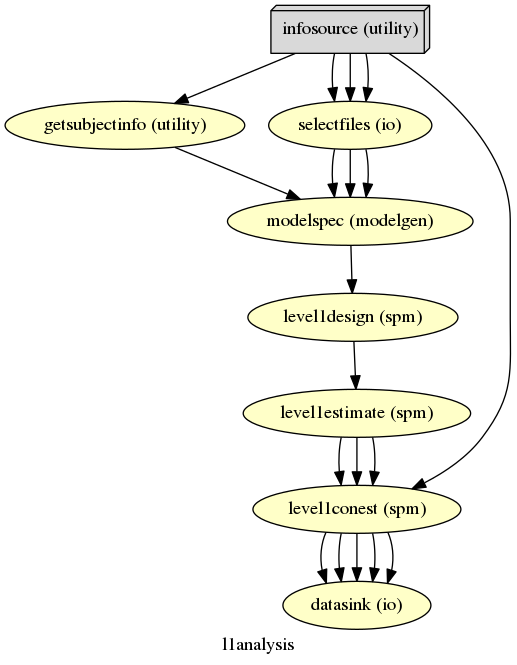

In [11]:
# Create 1st-level analysis output graph# Creat 
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))

In [ ]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 10})

181003-19:03:50,688 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
181003-19:03:59,990 nipype.workflow INFO:
	 Running in parallel.
181003-19:04:00,147 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 996 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 10/10.
181003-19:04:00,380 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2677_task_name_empathy/getsubjectinfo".181003-19:04:00,383 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2677_task_name_empathy/selectfiles".

181003-19:04:00,384 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2677_task_name_empathy/getsubjectinfo".181003-19:04:00,384 nipype.workflow INFO:
	 [Node] Setting-up

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2677_task_name_empathy/modelspec/art.asub-2677_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_3140_task_name_empathy/modelspec/art.asub-3140_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3140_task_name_empathy/modelspec/art.asub-3140_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)
/home/zohyos7/anaconda3/lib/pyt

181003-19:04:02,511 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:04:02,525 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")181003-19:04:02,526 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

181003-19:04:02,535 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
181003-19:04:02,542 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:04:02,546 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:04:02,561 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:04:02,563 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")181003-19:04:02,563 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
181003-19:04:02,564 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".

181003-19:04:02,

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_3043_task_name_empathy/modelspec/art.asub-3043_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:04:06,470 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:04:06,484 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
181003-19:04:06,496 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:04:06,521 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:04:08,143 nipype.workflow INFO:
	 [Job 51] Completed (l1analysis.modelspec).
181003-19:04:08,156 nipype.workflow INFO:
	 [Job 58] Completed (l1analysis.modelspec).
181003-19:04:08,167 nipype.workflow INFO:
	 [Job 63] Completed (l1analysis.getsubjectinfo).
181003-19:04:08,197 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 979 jobs ready. Free memory (GB): 111.82/113.22, Free processors: 3/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                      

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3043_task_name_empathy/modelspec/art.asub-3043_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:04:10,458 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:04:12,136 nipype.workflow INFO:
	 [Job 65] Completed (l1analysis.modelspec).
181003-19:04:12,157 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 977 jobs ready. Free memory (GB): 111.42/113.22, Free processors: 1/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
181003-19:04:12,410 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3043_task_name_empathy/level1design".


/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2528_task_name_empathy/modelspec/art.asub-2528_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:05:38,463 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:05:38,471 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:05:38,505 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:05:38,536 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:05:38,540 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:05:39,719 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
181003-19:05:40,226 nipype.workflow INFO:
	 [Job 68] Completed (l1analysis.level1conest).
181003-19:05:40,234 nipype.workflow INFO:
	 [Job 72] Completed (l1analysis.modelspec).
181003-19:05:40,242 nipype.workflow INFO:
	 [Job 79] Completed (l1analysis.modelspec).
181003-19:05:40,250 nipype.workflow INFO:
	 [Job 86] Completed (l1analysis.modelspec).
181003-19:05:40,257 nipype.workflow INFO:
	 [Job 91] Completed (l1analysis.getsubjectinfo).
181003-19:05:40,263 nipype.workflow INFO

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2528_task_name_empathy/modelspec/art.asub-2528_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)



181003-19:05:40,538 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")181003-19:05:40,539 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")181003-19:05:40,537 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3043_task_name_empathy/spmT_0003.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3043/task-empathy/fwhm-4//spmT_0003.nii
181003-19:05:40,539 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")


181003-19:05:40,542 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3043_task_name_empathy/spmT_0004.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3043/task-empathy/fwhm-4//spmT_0004.nii
181003-19:05:40,544 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3043_task_name_empathy/spmT_0005.nii -> /d

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2607_task_name_empathy/modelspec/art.asub-2607_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2607_task_name_empathy/modelspec/art.asub-2607_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:05:40,572 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3043_task_name_empathy/spmF_0018.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3043/task-empathy/fwhm-4//spmF_0018.nii
181003-19:05:40,574 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3043_task_name_empathy/spmF_0019.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3043/task-empathy/fwhm-4//spmF_0019.nii
181003-19:05:40,576 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3043_task_name_empathy/spmF_0020.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3043/task-empathy/fwhm-4//spmF_0020.nii181003-19:05:40,576 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".

181003-19:05:40,578 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3043_task_name_empathy/con_0001.nii -> /data/wellbeing_analysis/datasink/1s

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2800_task_name_empathy/modelspec/art.asub-2800_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:07:04,679 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_2661_task_name_empathy/spmT_0005.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2661/task-empathy/fwhm-4//spmT_0005.nii
181003-19:07:04,681 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_2661_task_name_empathy/spmT_0006.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2661/task-empathy/fwhm-4//spmT_0006.nii
181003-19:07:04,684 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_2661_task_name_empathy/spmT_0007.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2661/task-empathy/fwhm-4//spmT_0007.nii
181003-19:07:04,687 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_2661_task_name_empathy/spmT_0008.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2661/task-empathy/fwhm-4//spmT_0008.nii
181003-19:07:04,689 nipype.inter

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2800_task_name_empathy/modelspec/art.asub-2800_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:07:06,660 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
181003-19:07:06,667 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
181003-19:07:06,676 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:07:06,680 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")181003-19:07:06,680 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")

181003-19:07:06,688 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_2666_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-2666/task-empathy/fwhm-4//SPM.mat
181003-19:07:06,689 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
181003-19:07:06,691 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_2666_task_name_empathy/spmT_

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_3005_task_name_empathy/modelspec/art.asub-3005_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:07:16,601 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
181003-19:07:16,640 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:07:18,302 nipype.workflow INFO:
	 [Job 212] Completed (l1analysis.modelspec).
181003-19:07:18,319 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 935 jobs ready. Free memory (GB): 111.42/113.22, Free processors: 1/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
181003-19:07:18,524 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3005_task_name_empathy/modelspec/art.asub-3005_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:08:24,772 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2591_task_name_empathy/spmF_0018.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2591/task-empathy/fwhm-8//spmF_0018.nii

181003-19:08:24,775 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2591_task_name_empathy/spmF_0019.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2591/task-empathy/fwhm-8//spmF_0019.nii
181003-19:08:24,777 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2591_task_name_empathy/spmF_0020.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2591/task-empathy/fwhm-8//spmF_0020.nii
181003-19:08:24,779 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_2591_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-2591/task-empathy/fwhm-4//SPM.mat
181003-19:08:24,780 nipype.interface INFO:


/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2638_task_name_empathy/modelspec/art.asub-2638_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:11:16,883 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
181003-19:11:16,895 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
181003-19:11:16,902 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2655_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-2655/task-empathy/fwhm-8//SPM.mat
181003-19:11:16,905 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2655_task_name_empathy/spmT_0001.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2655/task-empathy/fwhm-8//spmT_0001.nii
181003-19:11:16,907 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2655_task_name_empathy/spmT_0002.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2655/task-empathy/fwhm-8//spmT_0002.nii
181003-19:11:16,909 nipype.interface INFO:
	 sub: /data/wellbei

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2638_task_name_empathy/modelspec/art.asub-2638_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:11:18,847 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
181003-19:11:18,848 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
181003-19:11:18,853 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2486_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-2486/task-empathy/fwhm-8//SPM.mat
181003-19:11:18,859 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2486_task_name_empathy/spmT_0001.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2486/task-empathy/fwhm-8//spmT_0001.nii
181003-19:11:18,862 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2486_task_name_empathy/spmT_0002.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2486/task-empathy/fwhm-8//spmT_0002.nii
181003-19:11:18,864 nipype.workflow INFO:
	 [Node] Finished "l1

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2622_task_name_empathy/modelspec/art.asub-2622_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:11:22,982 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:11:23,2 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
181003-19:11:23,9 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3090_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-3090/task-empathy/fwhm-4//SPM.mat
181003-19:11:23,11 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3090_task_name_empathy/spmT_0001.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3090/task-empathy/fwhm-4//spmT_0001.nii
181003-19:11:23,13 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3090_task_name_empathy/spmT_0002.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3090/task-empathy/fwhm-4//spmT_0002.nii
181003-19:11:23,15 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_i

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2622_task_name_empathy/modelspec/art.asub-2622_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)



181003-19:11:24,854 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")181003-19:11:24,855 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

181003-19:11:24,862 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
181003-19:11:24,865 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
181003-19:11:24,865 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:11:24,870 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_3090_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-3090/task-empathy/fwhm-8//SPM.mat
181003-19:11:24,871 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_3090_task_name_empathy/spmT_0001.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3090/task-empathy/fwhm-8//spmT_0001.nii
181003-19:11:24,872 

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2918_task_name_empathy/modelspec/art.asub-2918_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:12:46,922 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:12:46,990 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:12:48,614 nipype.workflow INFO:
	 [Job 450] Completed (l1analysis.modelspec).
181003-19:12:48,623 nipype.workflow INFO:
	 [Job 456] Completed (l1analysis.selectfiles).
181003-19:12:48,631 nipype.workflow INFO:
	 [Job 462] Completed (l1analysis.getsubjectinfo).
181003-19:12:48,639 nipype.workflow INFO:
	 [Job 463] Completed (l1analysis.selectfiles).
181003-19:12:48,665 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 865 jobs ready. Free memory (GB): 112.02/113.22, Free processors: 4/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1conest
                       * l1analysis.level1conest
                       * l1analy

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2918_task_name_empathy/modelspec/art.asub-2918_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:12:48,859 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
181003-19:12:48,873 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:12:48,878 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
181003-19:12:48,920 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:12:48,944 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:12:50,616 nipype.workflow INFO:
	 [Job 457] Completed (l1analysis.modelspec).
181003-19:12:50,625 nipype.workflow INFO:
	 [Job 464] Completed (l1analysis.modelspec).
181003-19:12:50,633 nipype.workflow INFO:
	 [Job 469] Completed (l1analysis.getsubjectinfo).
181003-19:12:50,659 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 863 jobs ready. Free memory (GB): 111.82/113.22, Free processors: 3/10.
                     Currently running:
                       * l1analysis.level1design

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2554_task_name_empathy/modelspec/art.asub-2554_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:13:04,952 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:13:06,569 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
181003-19:13:06,630 nipype.workflow INFO:
	 [Job 430] Completed (l1analysis.level1design).
181003-19:13:06,638 nipype.workflow INFO:
	 [Job 492] Completed (l1analysis.modelspec).
181003-19:13:06,665 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 856 jobs ready. Free memory (GB): 111.62/113.22, Free processors: 2/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
181003-19:13:06,857 nipype.workflow INFO:
	 [Node] Setting-up "l1anal

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2554_task_name_empathy/modelspec/art.asub-2554_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:14:05,9 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
181003-19:14:05,26 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
181003-19:14:05,33 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:14:05,45 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
181003-19:14:05,52 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".181003-19:14:05,52 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2918_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-2918/task-empathy/fwhm-8//SPM.mat

181003-19:14:05,55 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2918_task_name_empathy/spmT_0001.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2918/task-empathy/fwhm-8//spmT_0001.nii
181003-19:14:05,57 nipype.interface INFO:
	 sub: /

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_3002_task_name_empathy/modelspec/art.asub-3002_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:14:24,945 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:14:24,988 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:14:26,702 nipype.workflow INFO:
	 [Job 548] Completed (l1analysis.modelspec).
181003-19:14:26,709 nipype.workflow INFO:
	 [Job 553] Completed (l1analysis.getsubjectinfo).
181003-19:14:26,740 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 838 jobs ready. Free memory (GB): 111.62/113.22, Free processors: 2/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1conest
181003-19:14:26,984 nipype.workflow INFO:
	 [Node] Setting-up "l1

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3002_task_name_empathy/modelspec/art.asub-3002_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:14:29,65 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:14:29,69 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
181003-19:14:29,76 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_3024_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-3024/task-empathy/fwhm-8//SPM.mat
181003-19:14:29,78 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_3024_task_name_empathy/spmT_0001.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3024/task-empathy/fwhm-8//spmT_0001.nii
181003-19:14:29,80 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_3024_task_name_empathy/spmT_0002.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3024/task-empathy/fwhm-8//spmT_0002.nii
181003-19:14:29,82 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_3154_task_name_empathy/modelspec/art.asub-3154_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:14:35,37 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:14:35,972 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1design".
181003-19:14:36,707 nipype.workflow INFO:
	 [Job 521] Completed (l1analysis.level1design).
181003-19:14:36,715 nipype.workflow INFO:
	 [Job 562] Completed (l1analysis.modelspec).
181003-19:14:36,740 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 836 jobs ready. Free memory (GB): 111.62/113.22, Free processors: 2/10.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
181003-19:14:36,892 nipype.workflow INFO:
	 [Node] Setting-up "l

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3154_task_name_empathy/modelspec/art.asub-3154_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:15:31,75 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2935_task_name_empathy/getsubjectinfo".
181003-19:15:31,78 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
181003-19:15:31,79 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")181003-19:15:31,80 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")

181003-19:15:31,100 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:15:31,115 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:15:31,160 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:15:31,635 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
181003-19:15:32,761 nipype.workflow INFO:
	 [Job 537] Completed (l1analysis.level1conest).
1

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2603_task_name_empathy/modelspec/art.asub-2603_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:17:03,188 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:17:04,841 nipype.workflow INFO:
	 [Job 660] Completed (l1analysis.modelspec).
181003-19:17:04,847 nipype.workflow INFO:
	 [Job 666] Completed (l1analysis.selectfiles).
181003-19:17:04,853 nipype.workflow INFO:
	 [Job 672] Completed (l1analysis.getsubjectinfo).
181003-19:17:04,859 nipype.workflow INFO:
	 [Job 673] Completed (l1analysis.selectfiles).
181003-19:17:04,878 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 805 jobs ready. Free memory (GB): 112.02/113.22, Free processors: 4/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1conest
                       * l1analysis.level1conest
181003-19:17:05,59 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2603_task_name_empathy/modelspec/art.asub-2603_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:17:05,80 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3115_task_name_empathy/getsubjectinfo".
181003-19:17:05,86 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
181003-19:17:05,102 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")
181003-19:17:05,105 nipype.workflow INFO:
	 [Node] Running "modelspec" ("nipype.algorithms.modelgen.SpecifySPMModel")
181003-19:17:05,110 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:17:05,114 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".


/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_3115_task_name_empathy/modelspec/art.asub-3115_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:17:05,194 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:17:06,848 nipype.workflow INFO:
	 [Job 667] Completed (l1analysis.modelspec).
181003-19:17:06,857 nipype.workflow INFO:
	 [Job 674] Completed (l1analysis.modelspec).
181003-19:17:06,865 nipype.workflow INFO:
	 [Job 679] Completed (l1analysis.getsubjectinfo).
181003-19:17:06,890 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 803 jobs ready. Free memory (GB): 111.82/113.22, Free processors: 3/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1conest
                       * l1analysis.level1conest
181003-19:17:07,119 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/data/wellbeing_analysi

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3115_task_name_empathy/modelspec/art.asub-3115_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:17:09,182 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:17:10,840 nipype.workflow INFO:
	 [Job 681] Completed (l1analysis.modelspec).
181003-19:17:10,856 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 801 jobs ready. Free memory (GB): 111.42/113.22, Free processors: 1/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1conest
                       * l1analysis.level1design
                       * l1analysis.level1conest
                       * l1analysis.level1conest
181003-19:17:11,79 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3115_task_name_empathy/level1design".


/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2868_task_name_empathy/modelspec/art.asub-2868_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:19:03,270 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:19:04,946 nipype.workflow INFO:
	 [Job 772] Completed (l1analysis.modelspec).
181003-19:19:04,975 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 775 jobs ready. Free memory (GB): 111.42/113.22, Free processors: 1/10.
                     Currently running:
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
                       * l1analysis.level1design
                       * l1analysis.level1estimate
                       * l1analysis.level1estimate
181003-19:19:05,186 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.level1design" in "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2868_task_name_empathy/

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2868_task_name_empathy/modelspec/art.asub-2868_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:19:43,302 nipype.workflow INFO:
	 [Node] Running "level1conest" ("nipype.interfaces.spm.model.EstimateContrast")
181003-19:19:43,310 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:19:43,350 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:19:44,595 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
181003-19:19:44,912 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
181003-19:19:44,980 nipype.workflow INFO:
	 [Job 726] Completed (l1analysis.level1conest).
181003-19:19:44,989 nipype.workflow INFO:
	 [Job 733] Completed (l1analysis.level1conest).
181003-19:19:44,995 nipype.workflow INFO:
	 [Job 779] Completed (l1analysis.modelspec).
181003-19:19:45,1 nipype.workflow INFO:
	 [Job 784] Completed (l1analysis.getsubjectinfo).
181003-19:19:45,22 nipype.workflow INFO:
	 [MultiProc] Running 6 tasks, and 774 jobs ready. Free memory (GB): 112.02/113.22, Free processors: 4/10.
                     

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_3156_task_name_empathy/modelspec/art.asub-3156_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:19:51,283 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3188_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-3188/task-empathy/fwhm-4//SPM.mat
181003-19:19:51,287 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3188_task_name_empathy/spmT_0001.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3188/task-empathy/fwhm-4//spmT_0001.nii
181003-19:19:51,289 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3188_task_name_empathy/spmT_0002.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3188/task-empathy/fwhm-4//spmT_0002.nii
181003-19:19:51,292 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_4_subject_id_3188_task_name_empathy/spmT_0003.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-3188/task-empathy/fwhm-4//spmT_0003.nii
181003-19:19:51,295 nipype.interface INFO:
	

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_3156_task_name_empathy/modelspec/art.asub-3156_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:19:53,220 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
181003-19:19:53,233 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
181003-19:19:53,239 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:19:53,274 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:19:54,989 nipype.workflow INFO:
	 [Job 807] Completed (l1analysis.modelspec).
181003-19:19:54,997 nipype.workflow INFO:
	 [Job 812] Completed (l1analysis.getsubjectinfo).
181003-19:19:55,5 nipype.workflow INFO:
	 [Job 813] Completed (l1analysis.selectfiles).
181003-19:19:55,29 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 764 jobs ready. Free memory (GB): 111.82/113.22, Free processors: 3/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                  

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_8_subject_id_2793_task_name_empathy/modelspec/art.asub-2793_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)



181003-19:21:15,395 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
181003-19:21:15,399 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:21:15,402 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2839_task_name_empathy/SPM.mat -> /data/wellbeing_analysis/datasink/1stLevel/sub-2839/task-empathy/fwhm-8//SPM.mat
181003-19:21:15,404 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2839_task_name_empathy/spmT_0001.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2839/task-empathy/fwhm-8//spmT_0001.nii
181003-19:21:15,406 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwhm_id_8_subject_id_2839_task_name_empathy/spmT_0002.nii -> /data/wellbeing_analysis/datasink/1stLevel/sub-2839/task-empathy/fwhm-8//spmT_0002.nii
181003-19:21:15,408 nipype.interface INFO:
	 sub: /data/wellbeing_analysis/datasink/1stLevel/_fwh

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/modelgen.py:423: UserWarning: loadtxt: Empty input file: "/data/wellbeing_analysis/workingdir/l1analysis/_fwhm_id_4_subject_id_2793_task_name_empathy/modelspec/art.asub-2793_task-empathy_bold_outliers.txt"
  outindices = np.loadtxt(filename, dtype=int)


181003-19:21:17,323 nipype.workflow INFO:
	 [Node] Running "level1design" ("nipype.interfaces.spm.model.Level1Design")
181003-19:21:17,330 nipype.workflow INFO:
	 [Node] Finished "l1analysis.getsubjectinfo".
181003-19:21:17,347 nipype.workflow INFO:
	 [Node] Finished "l1analysis.modelspec".
181003-19:21:18,304 nipype.workflow INFO:
	 [Node] Finished "l1analysis.level1conest".
181003-19:21:19,64 nipype.workflow INFO:
	 [Job 824] Completed (l1analysis.level1conest).
181003-19:21:19,73 nipype.workflow INFO:
	 [Job 877] Completed (l1analysis.modelspec).
181003-19:21:19,82 nipype.workflow INFO:
	 [Job 882] Completed (l1analysis.getsubjectinfo).
181003-19:21:19,135 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 745 jobs ready. Free memory (GB): 111.82/113.22, Free processors: 3/10.
                     Currently running:
                       * l1analysis.level1design
                       * l1analysis.level1design
                       * l1analysis.level1design
                